<a href="https://colab.research.google.com/github/naoya1110/ai_robotics_lab_2024_hands_on/blob/main/Week06_Practical_Techniques_for_Training_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NCKU-NITKC AI Robotics Lab - Week 06

## Introduction

In this notebook, we will learn about practical techniques for training convolutional neural network (CNN) models such as


*   Data Standardization
*   Data Augmentation
*   Dropout Layer
*   L1, L2 Regularization
*   Transfer Learning



 As we saw last week, deep neural network models can easily overfit. Therefore, we always have to be careful not to overfit our models during training. However, thanks to the intensive researches in this field, many practical techniques for avoiding overfitting have been discovered. In this notebook, we will implement some of these techniques and see how they work.

### GPU

We will use a GPU to train CNN models. Please make sure your runtime type is GPU (cuda).

In [ ]:
import torch

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print(device)

cuda


In [ ]:
print(torch.cuda.get_device_name(0))
print(torch.cuda.get_device_properties(0))

Tesla T4
_CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15102MB, multi_processor_count=40)


### General Packages

Let's import general Python packages.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

## Data Preparation

### CIFAR10

We will use CIFAR10 dataset again.

In [ ]:
from torchvision.datasets import CIFAR10

train_dataset = CIFAR10(root="cifar10", train=True, download=True)
test_dataset = CIFAR10(root="cifar10", train=False, download=True)

classnames = {0:"plane",
              1:"car",
              2:"bird",
              3:"cat",
              4:"deer",
              5:"dog",
              6:"frog",
              7:"horse",
              8:"ship",
              9:"truck"}

Files already downloaded and verified
Files already downloaded and verified


### Data Standardization (aka. z-score normalization)

Data rescaling is often used as a preprocessing step in data preparation. One of the data rescaling methods is standardization (aka. z-score normalization). A raw data $x_i$ will be converted to a standardized data $z_i$ by the equation below, where $\mu$ and $\sigma$ are mean and standard deviation of the raw dataset, respectively.

$\displaystyle z_i=\dfrac{x_i-\mu}{\sigma}$

After the standardization, the mean and the standard deviation of the rescaled dataset will be 0 and 1 respectively.

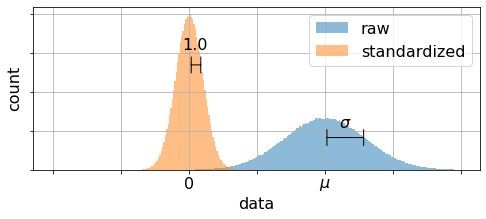

In order to standardize CIFAR10 image data, we need to know the means $\mu$ and the standard deviations $\sigma$ of red, green, blue pixels in the raw dataset. To do this, we first collect all red, green and blue pixels data in NumPy arrays.

In [ ]:
red_pixels = []
green_pixels = []
blue_pixels = []

for image, label in tqdm(train_dataset):
    image = np.array(image)/255.        # normalize data from 0-255 to 0.0-1.0
    image = image.astype("float32")

    red_pixels.append(image[:,:,0])     # take only red pixels
    green_pixels.append(image[:,:,1])   # take only green pixels
    blue_pixels.append(image[:,:,2])    # take only blue pixels

# convert data to 1D array
red_pixels = np.array(red_pixels).flatten()
green_pixels = np.array(green_pixels).flatten()
blue_pixels = np.array(blue_pixels).flatten()

print("number of red pixels", red_pixels.shape)
print("number of green pixels", green_pixels.shape)
print("number of blue pixels", blue_pixels.shape)

  0%|          | 0/50000 [00:00<?, ?it/s]

number of red pixels (51200000,)
number of green pixels (51200000,)
number of blue pixels (51200000,)


Let's take a look at their distributions.

(array([1551988., 2281534., 2971214., 3189966., 3747945., 3881195.,
        3823561., 3368245., 3428782., 3141754., 2837695., 2386688.,
        2341215., 2117185., 1936989., 1645889., 1617958., 1472561.,
        1328403., 2129233.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

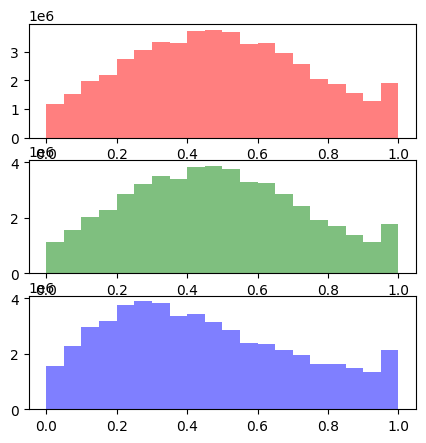

In [ ]:
plt.figure(figsize=(5, 5))

bins = np.arange(0, 1.01, 0.05)

plt.subplot(3, 1, 1)
plt.hist(red_pixels, bins=bins, color="r", alpha=0.5)

plt.subplot(3, 1, 2)
plt.hist(green_pixels, bins=bins, color="g", alpha=0.5)

plt.subplot(3, 1, 3)
plt.hist(blue_pixels, bins=bins, color="b", alpha=0.5)

Now we can determine means of red, green and blue pixels.

In [ ]:
means = (red_pixels.mean(), green_pixels.mean(), blue_pixels.mean())
means

(0.49139968, 0.48215827, 0.44653124)

Also standard deviations of red, green and blue pixels.

In [ ]:
stds = (red_pixels.std(), green_pixels.std(), blue_pixels.std())
stds

(0.24703233, 0.24348505, 0.26158768)

Then we can standardize the raw dataset by using `means` and `stds` data, and see how the standardized dataset distributes.

(array([      0.,       0.,       0.,       0.,       0.,       0.,
         898852., 1966181., 2732543., 3569531., 3693052., 3868509.,
        4139301., 3673354., 3447925., 3396936., 2837695., 2575272.,
        2490425., 2086986., 1916065., 1876472., 1569945., 1423793.,
        1400024., 1637139.,       0.,       0.,       0.,       0.]),
 array([-3.00000000e+00, -2.80000000e+00, -2.60000000e+00, -2.40000000e+00,
        -2.20000000e+00, -2.00000000e+00, -1.80000000e+00, -1.60000000e+00,
        -1.40000000e+00, -1.20000000e+00, -1.00000000e+00, -8.00000000e-01,
        -6.00000000e-01, -4.00000000e-01, -2.00000000e-01,  2.66453526e-15,
         2.00000000e-01,  4.00000000e-01,  6.00000000e-01,  8.00000000e-01,
         1.00000000e+00,  1.20000000e+00,  1.40000000e+00,  1.60000000e+00,
         1.80000000e+00,  2.00000000e+00,  2.20000000e+00,  2.40000000e+00,
         2.60000000e+00,  2.80000000e+00,  3.00000000e+00]),
 <BarContainer object of 30 artists>)

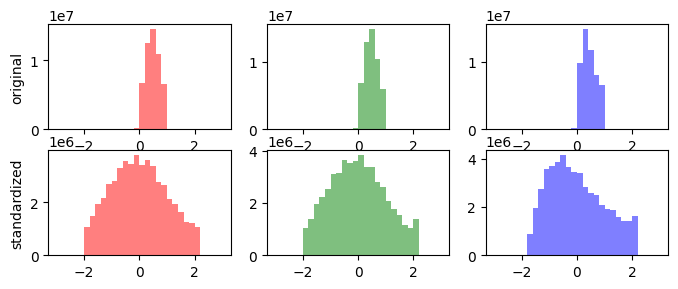

In [ ]:
# standardization
red_pixels_z = (red_pixels-means[0])/stds[0]
green_pixels_z = (green_pixels-means[1])/stds[1]
blue_pixels_z = (blue_pixels-means[2])/stds[2]

# visualize distributions
plt.figure(figsize=(8, 3))

bins=np.arange(-3,3.1,0.2)

plt.subplot(2, 3, 1)
plt.hist(red_pixels, bins=bins, color="r", alpha=0.5)
plt.ylabel("original")

plt.subplot(2, 3, 2)
plt.hist(green_pixels, bins=bins, color="g", alpha=0.5)

plt.subplot(2, 3, 3)
plt.hist(blue_pixels, bins=bins, color="b", alpha=0.5)

plt.subplot(2, 3, 4)
plt.hist(red_pixels_z, bins=bins, color="r", alpha=0.5)
plt.ylabel("standardized")

plt.subplot(2, 3, 5)
plt.hist(green_pixels_z, bins=bins, color="g", alpha=0.5)

plt.subplot(2, 3, 6)
plt.hist(blue_pixels_z, bins=bins, color="b", alpha=0.5)

We will use the `means` and `stds` data later when we reload the CIFAR10 dataset with `torch.tensor` format.

### Data Augmentation

Another technique often used for preprocessing is data augmentation. Data augmentation is a very powerful technique for preventing overfitting, especially when number of training data is limited. In each training epoch, slightly modified copies of the images are generated from the original images. This is effective to prevent the model from just remembering the training data because the model will never see exactly the same data again. The data augmention can be implemented easily using `torchvision.transforms.v2` module.

Here we take one image from training data and let's see how this image can be augmented.

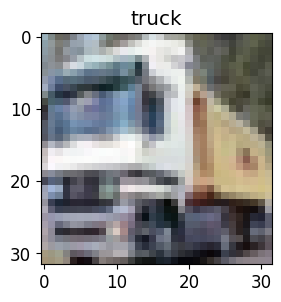

In [ ]:
image, label = train_dataset[1]

plt.figure(figsize=(5,3))
plt.rcParams["font.size"]=12
plt.imshow(image)
plt.title(classnames[label])

x = image

#### Random Horizontal Flip



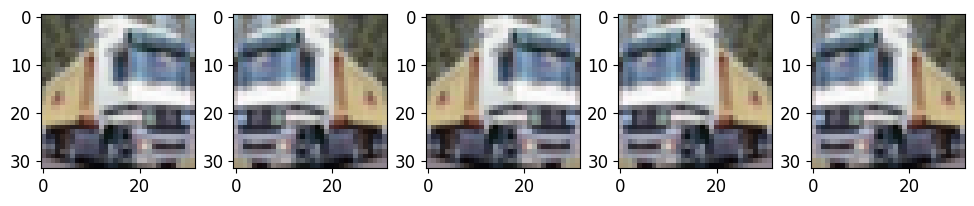

In [ ]:
from torchvision.transforms import v2
transform = v2.RandomHorizontalFlip(p=0.5)

def show_transformed_images(transform, x):
    plt.figure(figsize=(12, 2))
    for i in range(5):
        output_image = transform(x)
        plt.subplot(1, 5, i+1)
        plt.imshow(output_image)

show_transformed_images(transform, x)

#### Random Vertical Flip

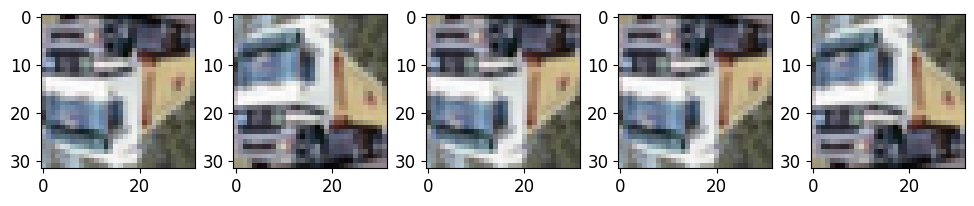

In [ ]:
transform = v2.RandomVerticalFlip(p=0.5)

show_transformed_images(transform, x)

#### Random Roation

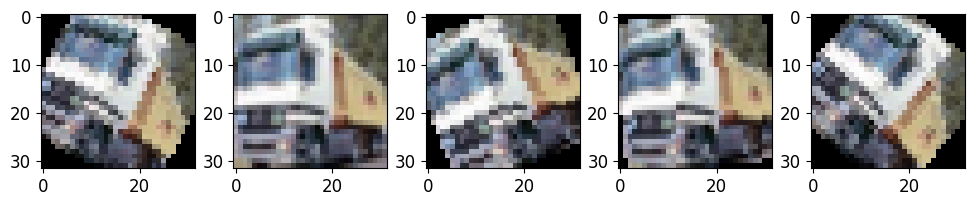

In [ ]:
transform = v2.RandomRotation(degrees=45)

show_transformed_images(transform, x)

#### Random Perspective

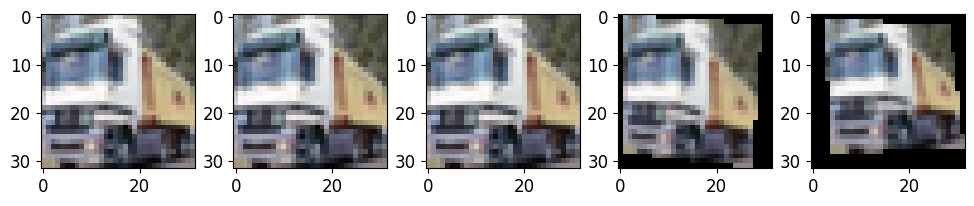

In [ ]:
transform = v2.RandomPerspective(distortion_scale=0.3, p=0.5)

show_transformed_images(transform, x)

#### Compose Transforms
We can combine several different transoforms using `transform.Compose()`.

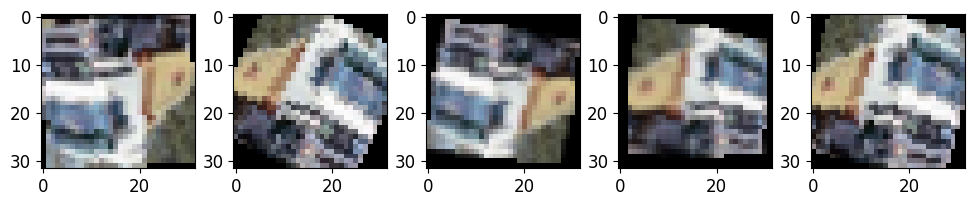

In [ ]:
transform = v2.Compose([
                v2.RandomHorizontalFlip(p=0.5),
                v2.RandomVerticalFlip(p=0.5),
                v2.RandomRotation(degrees=30),
                v2.RandomPerspective(distortion_scale=0.3, p=0.5)
                ])

show_transformed_images(transform, x)

There are lots of other transforms modules that can be used for data augmentation. Please refer the information below.

`torchvision.transforms` https://pytorch.org/vision/stable/transforms.html

### Reload Data

Now we reload CIFAR10 dataset in `torch.tensor` format. At the same time, we apply the data standardization and the data augmentation. The standardization should be applied for both of the train and the test data, but the data augmentation should be applied to the train data only.

In [ ]:
from torchvision.transforms import v2

train_dataset = CIFAR10(root="cifar10",
                        train=True,
                        download=False,
                        transform=v2.Compose([
                            v2.ToTensor(),               # convert to torch.tensor
                            v2.Normalize(means, stds),   # standardization

                            # data augmentation
                            v2.RandomHorizontalFlip(p=0.5),
                            # v2.RandomVerticalFlip(p=0.5),
                            v2.RandomRotation(degrees=10),
                            # v2.RandomPerspective(distortion_scale=0.3, p=0.5)
                            ])
                   )

test_dataset = CIFAR10(root="cifar10",
                        train=False,
                        download=False,
                        transform=v2.Compose([
                            v2.ToTensor(),                # convert to torch.tensor
                            v2.Normalize(means, stds)     # standardization
                            ])
                   )

### DataLoader

Then we create `DataLoader` objects for feeding data to the model. This is exactly same as we did with Iris dataset.

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=200, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=200, shuffle=False)

That's it for data preparation!

## Model Building

### Design from Scratch

Next step is to build a convolutional neural network (CNN) and load it to GPU. The model we define here is identical to what we used last week, except for the dropout layer in the classifier.

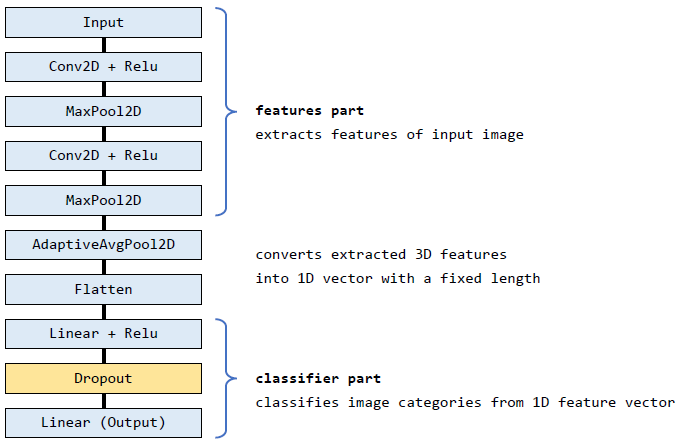

In [ ]:
import torch.nn as nn

# define a class named "Model"
class Model(nn.Module):

    # Constructor
    def __init__(self):                 # do not change
        super(Model, self).__init__()   # do not change

        # define a network module named "features"
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        # define a network module named "junction"
        self.junction = nn.Sequential(
            nn.AdaptiveAvgPool2d(output_size=(8, 8)),
            nn.Flatten()
        )

        # define a network module named "classifier"
        self.classifier = nn.Sequential(
            nn.Linear(in_features=64*8*8, out_features=256),
            nn.ReLU(),
            nn.Dropout(p=0.3), # Dropout Layer
            nn.Linear(in_features=256, out_features=10)
        )

    # Instance method
    def forward(self, x):   # do not change
        x = self.features(x)
        x = self.junction(x)
        x = self.classifier(x)
        return x

model = Model()    # construct an instance of the Model class
print(model)

Model(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (junction): Sequential(
    (0): AdaptiveAvgPool2d(output_size=(8, 8))
    (1): Flatten(start_dim=1, end_dim=-1)
  )
  (classifier): Sequential(
    (0): Linear(in_features=4096, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=10, bias=True)
  )
)


#### Dropout Layer

The dropout layer makes some of the neurons from previous layer to be 0 randomly with the probability of `p` during training. Since less information will propagete through the dropout layer, the model will be trained under more difficult situation. This will make the model more rubust.

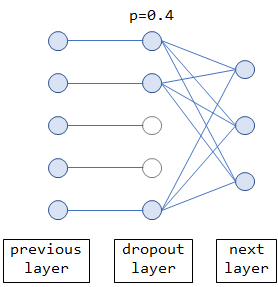

The dropout layer can be implemented with `nn.Dropout()`. The parameter `p` indicates the probabitlty of neurons to be 0 with a Bernoulli distribution. Also non-zero nodes will be scaled by a factor of 1/(1-p).

`nn.Dropout()` https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html

In [ ]:
x = torch.ones(10)
dropout = nn.Dropout(p=0.5)
y = dropout(x)
print("input", x)
print("output", y)

input tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
output tensor([2., 2., 0., 0., 0., 2., 2., 2., 0., 2.])


#### torchinfo
Let's see the model archtecture.

In [ ]:
! pip install torchinfo
from torchinfo import summary

for x_batch, _ in train_loader:
    break

input_shape = x_batch.shape
print(input_shape)

summary(model, input_shape)

torch.Size([200, 3, 32, 32])


Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [200, 10]                 --
├─Sequential: 1-1                        [200, 64, 8, 8]           --
│    └─Conv2d: 2-1                       [200, 64, 32, 32]         1,792
│    └─ReLU: 2-2                         [200, 64, 32, 32]         --
│    └─MaxPool2d: 2-3                    [200, 64, 16, 16]         --
│    └─Conv2d: 2-4                       [200, 64, 16, 16]         36,928
│    └─ReLU: 2-5                         [200, 64, 16, 16]         --
│    └─MaxPool2d: 2-6                    [200, 64, 8, 8]           --
├─Sequential: 1-2                        [200, 4096]               --
│    └─AdaptiveAvgPool2d: 2-7            [200, 64, 8, 8]           --
│    └─Flatten: 2-8                      [200, 4096]               --
├─Sequential: 1-3                        [200, 10]                 --
│    └─Linear: 2-9                       [200, 256]                1,048,832
│

### Transfer Learning (Re-train Pretrained Model)

So far, we have learned how to build and train deep neural network models from scratch. Transfer learning is a technique to shortcut some of these processes. Starting point of the transfer learning is a model already trained with other dataset. Such model is called a ***pretrained model***. Then the pretrained model will be trained with a new dataset. In some cases, only a part of parameters (weights and biases) in the pretrained model will be retrained while rest of them are fixed as pretrained. By employing the transfer learning, the model can reach higher performance with less training time compared with training it from scratch.

#### Load Pretrained Model
The pretrained models can be downloaded using `torchvison.models`. We will use a model called VGG16 which is one of the well-known image classification models. By specifying `models.vgg16(weights="IMAGENET1K_V1")`, we can load the VGG16 model pretrained with the dataset called ImageNet. ImageNet dataset consists of more than 1.2 million images with 1000 categories.

VGG16 Original Paper https://arxiv.org/abs/1409.1556

ImageNet Dataset https://www.image-net.org/update-mar-11-2021.php

In [ ]:
import torchvision.models as models

model = models.vgg16(weights="IMAGENET1K_V1")
print(model)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:09<00:00, 60.5MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

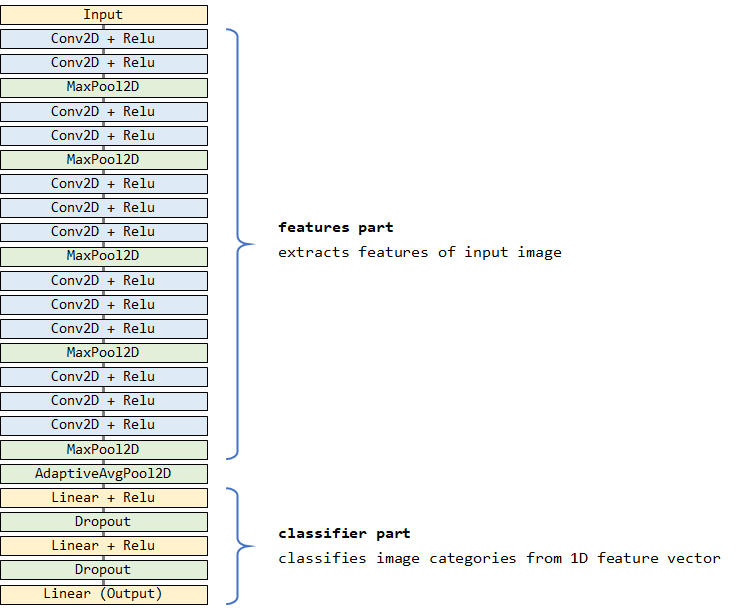

#### Replace Output Layer
The number of output neurons of the pretrained VGG16 model is 1000. This is because this model is designed for classifying 1000 categories of images.

In [ ]:
model.classifier[6]

Linear(in_features=4096, out_features=1000, bias=True)

Since we are going to classify CIFAR10 dataset, the number of output neurons needs to be 10. Therefore we have to replace the last layer.

In [ ]:
model.classifier[6] = nn.Linear(4096, 10)   # replace the last layer
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
! pip install torchinfo
from torchinfo import summary

for x_batch, _ in train_loader:
    break

input_shape = x_batch.shape
print(input_shape)

summary(model, input_shape)

torch.Size([200, 3, 32, 32])


Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [200, 10]                 --
├─Sequential: 1-1                        [200, 512, 1, 1]          --
│    └─Conv2d: 2-1                       [200, 64, 32, 32]         1,792
│    └─ReLU: 2-2                         [200, 64, 32, 32]         --
│    └─Conv2d: 2-3                       [200, 64, 32, 32]         36,928
│    └─ReLU: 2-4                         [200, 64, 32, 32]         --
│    └─MaxPool2d: 2-5                    [200, 64, 16, 16]         --
│    └─Conv2d: 2-6                       [200, 128, 16, 16]        73,856
│    └─ReLU: 2-7                         [200, 128, 16, 16]        --
│    └─Conv2d: 2-8                       [200, 128, 16, 16]        147,584
│    └─ReLU: 2-9                         [200, 128, 16, 16]        --
│    └─MaxPool2d: 2-10                   [200, 128, 8, 8]          --
│    └─Conv2d: 2-11                      [200, 256, 8, 8]          29

#### Freeze Parameters
The pretrained VGG16 model is well-trained with the ImageNet dataset, therefore the model parameters (weights and biases) are already good for general image classification tasks. In such case, it might be better to keep (freeze) most of the parameters in the model and re-train only a few layers of the model with the new dataset.

In order to do so, we make all of the parameters in the model to be frozen by setting `requires_grad=False`.

In [ ]:
for param in model.parameters():
    param.requires_grad = False

Then we set `requires_grad=Ture` to some specific layers so that they will be trained.

For example if we want to train only the parameters in the last layer (`model.classfier[6]`, 6th layer in the classifier part), we can do

In [ ]:
model.classifier[6].weight.requires_grad = True
model.classifier[6].bias.requires_grad = True

If we want to train other layers, we can do like

In [ ]:
# 0th layer in the classifier part
model.classifier[0].weight.requires_grad = True
model.classifier[0].bias.requires_grad = True

# 3rd layer in the classifier part
model.classifier[3].weight.requires_grad = True
model.classifier[3].bias.requires_grad = True

#### torchinfo
Let's see how the data shape changes in the model.

In [ ]:
for x_batch, _ in train_loader:
    break

input_shape = x_batch.shape
print(input_shape)

summary(model, input_shape)

torch.Size([200, 3, 32, 32])


Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [200, 10]                 --
├─Sequential: 1-1                        [200, 512, 1, 1]          --
│    └─Conv2d: 2-1                       [200, 64, 32, 32]         (1,792)
│    └─ReLU: 2-2                         [200, 64, 32, 32]         --
│    └─Conv2d: 2-3                       [200, 64, 32, 32]         (36,928)
│    └─ReLU: 2-4                         [200, 64, 32, 32]         --
│    └─MaxPool2d: 2-5                    [200, 64, 16, 16]         --
│    └─Conv2d: 2-6                       [200, 128, 16, 16]        (73,856)
│    └─ReLU: 2-7                         [200, 128, 16, 16]        --
│    └─Conv2d: 2-8                       [200, 128, 16, 16]        (147,584)
│    └─ReLU: 2-9                         [200, 128, 16, 16]        --
│    └─MaxPool2d: 2-10                   [200, 128, 8, 8]          --
│    └─Conv2d: 2-11                      [200, 256, 8, 8]    

## Training

### Loss Function

We use the cross-entropy loss as the loss function since this is a classification task.

In [ ]:
loss_func = nn.CrossEntropyLoss()

### Optimizer

We use the Adam optimizer.

In [ ]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=1E-3)

### L1/L2 Regularization

L1 and L2 regularizations are implemented by adding a parameter norm penalty $\Omega$ to the loss value $\mathrm{loss}_0$ that is determined by the loss function such as `nn.CrossEntropyLoss()` as shown below.

$\mathrm{loss} = \mathrm{loss}_0 + \alpha\Omega$

where $\alpha$ is the relative contribution factor of $\Omega$.

#### L2 Norm Penalty
L2 norm penalty $\Omega_{L2}$ is adding-up by cumulating the squared value of all weights in the model as shown below.

$\displaystyle \Omega_{L2}=\sum_i w_i^2$

In [ ]:
def get_l2_norm(model=model):
    l2_norm = 0
    for p in model.parameters():
        l2_norm += p.pow(2).sum()
    return l2_norm

print("L2 Norm Penalty:", get_l2_norm(model).item())

L2 Norm Penalty: 9893.8076171875


#### L1 Regularization
L1 norm penalty $\Omega_{L1}$ is calculated by cumulating the absolute value of all weights in the model as shown below.

$\displaystyle \Omega_{L1}=\sum_{i} |w_i|$

In [ ]:
def get_l1_norm(model=model):
    l1_norm = 0
    for p in model.parameters():
        l1_norm += p.abs().sum()
    return l1_norm

print("L1 Norm Penalty:", get_l1_norm(model).item())

L1 Norm Penalty: 751622.4375


### Save Model Parameters

It is also a good idea to save the model parameters during the training so that we can load it later. We can do this with the code below.

In [ ]:
model_path = "my_model.pth"
torch.save(model.state_dict(), model_path)

### Training Loop

Now we can train the model.

This time we save the model parameters after each epoch if the test accuracy is better than before. Then later we can load the best model.







In [ ]:
use_pretrained_model = False


if use_pretrained_model:
    model = models.vgg16(weights="IMAGENET1K_V1")    # load pretrained model
    model.classifier[6] = nn.Linear(4096, 10)        # replace the last Linear layer

    for param in model.parameters():                 # freeze all parameters
        param.requires_grad = False

    # enable training for the specific layers
    model.classifier[0].weight.requires_grad = True
    model.classifier[0].bias.requires_grad = True
    model.classifier[3].weight.requires_grad = True
    model.classifier[3].bias.requires_grad = True
    model.classifier[6].weight.requires_grad = True
    model.classifier[6].bias.requires_grad = True

else :
    model = Model() # use your custom model

model = model.to(device)                               # load model onto GPU
loss_func = nn.CrossEntropyLoss()                      # set loss function
optimizer = optim.Adam(model.parameters(), lr=1E-3)    # set optimizer
epochs = 50

best_model_path = 'best_model.pth'
best_accuracy = 0.0

# create empty lists for saving metrics during training
train_loss_list = []
train_accuracy_list = []
test_loss_list = []
test_accuracy_list = []

for epoch in range(epochs):
    print("-----------------------------")
    print(f"Epoch {epoch+1}/{epochs}")

    # initialize metrics
    train_correct_count = 0
    train_accuracy = 0
    train_loss = 0
    test_correct_count = 0
    test_accuracy = 0
    test_loss = 0

    #--- Training Phase ---#
    model.train()    # set model to training mode

    pbar = tqdm(train_loader)
    pbar.set_description("Train")

    for x_batch, y_batch in pbar:      # take mini batch data from train_loader

        x_batch = x_batch.to(device)     # load x_batch data on GPU
        y_batch = y_batch.to(device)     # load y_batch data on GPU

        optimizer.zero_grad()                  # reset gradients to 0
        p_batch = model(x_batch)               # do prediction
        loss = loss_func(p_batch, y_batch)     # measure loss

        #--- L1/L2 regularizaiton ---#
        # alpha = 0.001
        # loss = loss + alpha * get_l2_norm(model)    # add L2 penalty
        # loss = loss + alpha * get_l1_norm(model)  # add L1 penalty
        #----------------------------#

        loss.backward()                        # calculate gradients
        optimizer.step()                       # update model parameters

        train_loss += loss.item()                                # accumulate loss value
        p_batch_label = torch.argmax(p_batch, dim=1)             # convert p_batch vector to p_batch_label
        train_correct_count += (p_batch_label == y_batch).sum()  # count up number of correct predictions

        pbar.set_postfix({"accuracy":f"{(p_batch_label == y_batch).sum()/len(x_batch):.4f}", "loss": f"{loss.item():.4f}"})
    #----------------------#

    #--- Evaluation Phase ---#
    with torch.no_grad():   # disable autograd for saving memory usage
        model.eval()        # set model to evaluation mode

        pbar = tqdm(test_loader)
        pbar.set_description("Test")

        for x_batch, y_batch in pbar:   # take mini batch data from test_loader

            x_batch = x_batch.to(device)     # load x_batch data on GPU
            y_batch = y_batch.to(device)     # load y_batch data on GPU

            p_batch = model(x_batch)              # do prediction
            loss = loss_func(p_batch, y_batch)    # measure loss

            #--- L1/L2 regularizaiton ---#
            # loss = loss + alpha * get_l2_norm(model)    # add L2 penalty
            # loss = loss + alpha * get_l1_norm(model)  # add L1 penalty
            #----------------------------#

            test_loss += loss.item()                                # add up loss value

            p_batch_label = torch.argmax(p_batch, dim=1)            # convert p_batch vector to p_batch_label
            test_correct_count += (p_batch_label == y_batch).sum()  # count up number of correct predictions

            pbar.set_postfix({"accuracy":f"{(p_batch_label == y_batch).sum()/len(x_batch):.4f}", "loss": f"{loss.item():.4f}"})
    #------------------------#

    train_accuracy = train_correct_count.item()/len(train_dataset)   # determine accuracy for training data
    test_accuracy = test_correct_count.item()/len(test_dataset)      # determine accuracy for test data
    train_loss = train_loss/len(train_loader)                 # determine loss for training data
    test_loss = test_loss/len(test_loader)                    # determine loss for test data

    # show and store metrics
    print(f"Train: Accuracy={train_accuracy:.3f} Loss={train_loss:.3f}, Test: Accuracy={test_accuracy:.3f} Loss={test_loss:.3f}")
    train_accuracy_list.append(train_accuracy)
    train_loss_list.append(train_loss)
    test_accuracy_list.append(test_accuracy)
    test_loss_list.append(test_loss)

    # save the model if test accuracy is better than before
    if test_accuracy > best_accuracy:
        torch.save(model.state_dict(), best_model_path)
        print(f"Test accuracy improved from {best_accuracy:.3f} to {test_accuracy:.3f}")
        print(f"Model saved at {best_model_path}")
        best_accuracy = test_accuracy

-----------------------------
Epoch 1/50


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Train: Accuracy=0.476 Loss=1.447, Test: Accuracy=0.592 Loss=1.142
Test accuracy improved from 0.000 to 0.592
Model saved at best_model.pth
-----------------------------
Epoch 2/50


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Train: Accuracy=0.608 Loss=1.104, Test: Accuracy=0.662 Loss=0.964
Test accuracy improved from 0.592 to 0.662
Model saved at best_model.pth
-----------------------------
Epoch 3/50


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Train: Accuracy=0.657 Loss=0.975, Test: Accuracy=0.685 Loss=0.900
Test accuracy improved from 0.662 to 0.685
Model saved at best_model.pth
-----------------------------
Epoch 4/50


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Train: Accuracy=0.684 Loss=0.898, Test: Accuracy=0.706 Loss=0.835
Test accuracy improved from 0.685 to 0.706
Model saved at best_model.pth
-----------------------------
Epoch 5/50


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Train: Accuracy=0.707 Loss=0.833, Test: Accuracy=0.719 Loss=0.802
Test accuracy improved from 0.706 to 0.719
Model saved at best_model.pth
-----------------------------
Epoch 6/50


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Train: Accuracy=0.724 Loss=0.789, Test: Accuracy=0.731 Loss=0.780
Test accuracy improved from 0.719 to 0.731
Model saved at best_model.pth
-----------------------------
Epoch 7/50


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Train: Accuracy=0.738 Loss=0.749, Test: Accuracy=0.740 Loss=0.745
Test accuracy improved from 0.731 to 0.740
Model saved at best_model.pth
-----------------------------
Epoch 8/50


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Train: Accuracy=0.747 Loss=0.722, Test: Accuracy=0.751 Loss=0.724
Test accuracy improved from 0.740 to 0.751
Model saved at best_model.pth
-----------------------------
Epoch 9/50


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Train: Accuracy=0.758 Loss=0.688, Test: Accuracy=0.750 Loss=0.712
-----------------------------
Epoch 10/50


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Train: Accuracy=0.770 Loss=0.660, Test: Accuracy=0.766 Loss=0.692
Test accuracy improved from 0.751 to 0.766
Model saved at best_model.pth
-----------------------------
Epoch 11/50


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Train: Accuracy=0.777 Loss=0.636, Test: Accuracy=0.763 Loss=0.688
-----------------------------
Epoch 12/50


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Train: Accuracy=0.785 Loss=0.609, Test: Accuracy=0.769 Loss=0.677
Test accuracy improved from 0.766 to 0.769
Model saved at best_model.pth
-----------------------------
Epoch 13/50


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Train: Accuracy=0.787 Loss=0.602, Test: Accuracy=0.768 Loss=0.674
-----------------------------
Epoch 14/50


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Train: Accuracy=0.796 Loss=0.575, Test: Accuracy=0.768 Loss=0.679
-----------------------------
Epoch 15/50


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Train: Accuracy=0.801 Loss=0.563, Test: Accuracy=0.757 Loss=0.701
-----------------------------
Epoch 16/50


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Train: Accuracy=0.807 Loss=0.546, Test: Accuracy=0.776 Loss=0.660
Test accuracy improved from 0.769 to 0.776
Model saved at best_model.pth
-----------------------------
Epoch 17/50


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Train: Accuracy=0.813 Loss=0.529, Test: Accuracy=0.775 Loss=0.666
-----------------------------
Epoch 18/50


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Train: Accuracy=0.818 Loss=0.511, Test: Accuracy=0.769 Loss=0.686
-----------------------------
Epoch 19/50


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Train: Accuracy=0.820 Loss=0.507, Test: Accuracy=0.776 Loss=0.673
-----------------------------
Epoch 20/50


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Train: Accuracy=0.825 Loss=0.490, Test: Accuracy=0.783 Loss=0.675
Test accuracy improved from 0.776 to 0.783
Model saved at best_model.pth
-----------------------------
Epoch 21/50


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Train: Accuracy=0.828 Loss=0.479, Test: Accuracy=0.778 Loss=0.673
-----------------------------
Epoch 22/50


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Train: Accuracy=0.832 Loss=0.467, Test: Accuracy=0.778 Loss=0.694
-----------------------------
Epoch 23/50


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Train: Accuracy=0.835 Loss=0.458, Test: Accuracy=0.782 Loss=0.663
-----------------------------
Epoch 24/50


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Train: Accuracy=0.840 Loss=0.448, Test: Accuracy=0.777 Loss=0.677
-----------------------------
Epoch 25/50


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Train: Accuracy=0.841 Loss=0.443, Test: Accuracy=0.783 Loss=0.693
Test accuracy improved from 0.783 to 0.783
Model saved at best_model.pth
-----------------------------
Epoch 26/50


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Train: Accuracy=0.842 Loss=0.438, Test: Accuracy=0.784 Loss=0.695
Test accuracy improved from 0.783 to 0.784
Model saved at best_model.pth
-----------------------------
Epoch 27/50


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Train: Accuracy=0.847 Loss=0.427, Test: Accuracy=0.784 Loss=0.701
Test accuracy improved from 0.784 to 0.784
Model saved at best_model.pth
-----------------------------
Epoch 28/50


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Train: Accuracy=0.849 Loss=0.420, Test: Accuracy=0.782 Loss=0.683
-----------------------------
Epoch 29/50


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Train: Accuracy=0.855 Loss=0.406, Test: Accuracy=0.788 Loss=0.678
Test accuracy improved from 0.784 to 0.788
Model saved at best_model.pth
-----------------------------
Epoch 30/50


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Train: Accuracy=0.857 Loss=0.401, Test: Accuracy=0.790 Loss=0.700
Test accuracy improved from 0.788 to 0.790
Model saved at best_model.pth
-----------------------------
Epoch 31/50


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Train: Accuracy=0.858 Loss=0.394, Test: Accuracy=0.789 Loss=0.705
-----------------------------
Epoch 32/50


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Train: Accuracy=0.859 Loss=0.388, Test: Accuracy=0.785 Loss=0.703
-----------------------------
Epoch 33/50


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Train: Accuracy=0.862 Loss=0.380, Test: Accuracy=0.786 Loss=0.734
-----------------------------
Epoch 34/50


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Train: Accuracy=0.864 Loss=0.375, Test: Accuracy=0.787 Loss=0.704
-----------------------------
Epoch 35/50


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Train: Accuracy=0.868 Loss=0.366, Test: Accuracy=0.788 Loss=0.702
-----------------------------
Epoch 36/50


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Train: Accuracy=0.868 Loss=0.369, Test: Accuracy=0.787 Loss=0.724
-----------------------------
Epoch 37/50


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Train: Accuracy=0.869 Loss=0.363, Test: Accuracy=0.786 Loss=0.715
-----------------------------
Epoch 38/50


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Train: Accuracy=0.869 Loss=0.358, Test: Accuracy=0.792 Loss=0.722
Test accuracy improved from 0.790 to 0.792
Model saved at best_model.pth
-----------------------------
Epoch 39/50


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Train: Accuracy=0.873 Loss=0.347, Test: Accuracy=0.788 Loss=0.725
-----------------------------
Epoch 40/50


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Train: Accuracy=0.876 Loss=0.343, Test: Accuracy=0.795 Loss=0.737
Test accuracy improved from 0.792 to 0.795
Model saved at best_model.pth
-----------------------------
Epoch 41/50


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Train: Accuracy=0.875 Loss=0.346, Test: Accuracy=0.788 Loss=0.720
-----------------------------
Epoch 42/50


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Train: Accuracy=0.878 Loss=0.338, Test: Accuracy=0.783 Loss=0.769
-----------------------------
Epoch 43/50


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Train: Accuracy=0.878 Loss=0.336, Test: Accuracy=0.783 Loss=0.770
-----------------------------
Epoch 44/50


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Train: Accuracy=0.879 Loss=0.330, Test: Accuracy=0.789 Loss=0.758
-----------------------------
Epoch 45/50


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Train: Accuracy=0.884 Loss=0.325, Test: Accuracy=0.788 Loss=0.751
-----------------------------
Epoch 46/50


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Train: Accuracy=0.884 Loss=0.320, Test: Accuracy=0.786 Loss=0.768
-----------------------------
Epoch 47/50


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Train: Accuracy=0.881 Loss=0.324, Test: Accuracy=0.788 Loss=0.770
-----------------------------
Epoch 48/50


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Train: Accuracy=0.886 Loss=0.314, Test: Accuracy=0.787 Loss=0.751
-----------------------------
Epoch 49/50


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Train: Accuracy=0.887 Loss=0.316, Test: Accuracy=0.788 Loss=0.762
-----------------------------
Epoch 50/50


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Train: Accuracy=0.886 Loss=0.316, Test: Accuracy=0.786 Loss=0.773


### Learning Curves

Let's visualize the accuracy and the loss curves for train and test data.

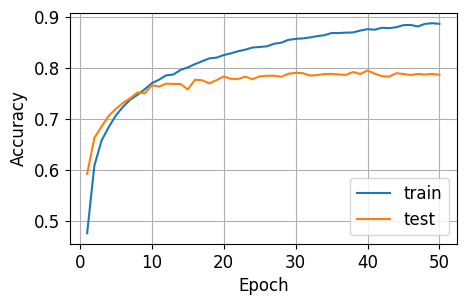

In [ ]:
plt.figure(figsize=(5,3))
plt.rcParams["font.size"]=12
plt.plot(np.arange(epochs)+1, train_accuracy_list, label="train")
plt.plot(np.arange(epochs)+1, test_accuracy_list, label="test")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()

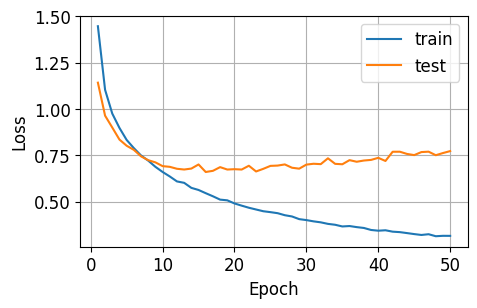

In [ ]:
plt.figure(figsize=(5,3))
plt.rcParams["font.size"]=12
plt.plot(np.arange(epochs)+1, train_loss_list, label="train")
plt.plot(np.arange(epochs)+1, test_loss_list, label="test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.legend()

As you see above, the test accuracy keeps increasing even after 10 epochs and is still higher than the train accuracy. Similarly the test loss keeps decreasing even after 10 epochs and still lower than the test loss. This is a sign of that the model is not overfitted yet. Therefore we can continue training the model further or we can use a larger model.

## Evaluation

### Load the Best Model

Now we can load the best model. What we saved in `best_model.pth` is only the model parameters. So first we need to load an initialized (not trained) model and then load the trained model parameters in there.

In [ ]:
if use_pretrained_model:
    model = models.vgg16(pretrained=False)            # load pretrained model
    model.classifier[6] = nn.Linear(4096, 10)        # replace the last Linear layer

else:
    model = Model()

model = model.to(device)                           # load an initialized model
model.load_state_dict(torch.load(best_model_path))   # load model parameters to the initialized model

<ipython-input-50-e40ef534eace>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))   # load model parameters to the initiali

<All keys matched successfully>

### Test Accuracy

We should check accuracy of the model for all of the test data.

In [ ]:
test_accuracy = 0

y_test_all = np.array([])
p_label_all = np.array([])

with torch.no_grad():    # disable autograd
    model.eval()         # set model to evaluation mode

    for x_batch, y_batch in test_loader:    # take mini batch data from train_loader
        x_batch = x_batch.to(device)        # transfer x_batch to gpu
        y_batch = y_batch.to(device)        # transfer y_batch to gpu
        p_batch = model(x_batch)            # do prediction

        p_batch_label = torch.argmax(p_batch, dim=1)       # convert p_batch vector to p_batch_label
        test_accuracy += (p_batch_label == y_batch).sum()  # count up number of correct predictions

        y_test_all = np.append(y_test_all, y_batch.to("cpu").numpy())          # append y_batch in y_test_all
        p_label_all = np.append(p_label_all, p_batch_label.to("cpu").numpy())  # append p_batch_label in p_label_all

test_accuracy = test_accuracy/len(test_dataset)      # determine accuracy for test data
print(f"Test Accuracy = {test_accuracy:.3f}")

Test Accuracy = 0.795


### Confusion Matrix

Then let's check the confusion matrix.

Text(0.5, 1.0, 'confusion matrix')

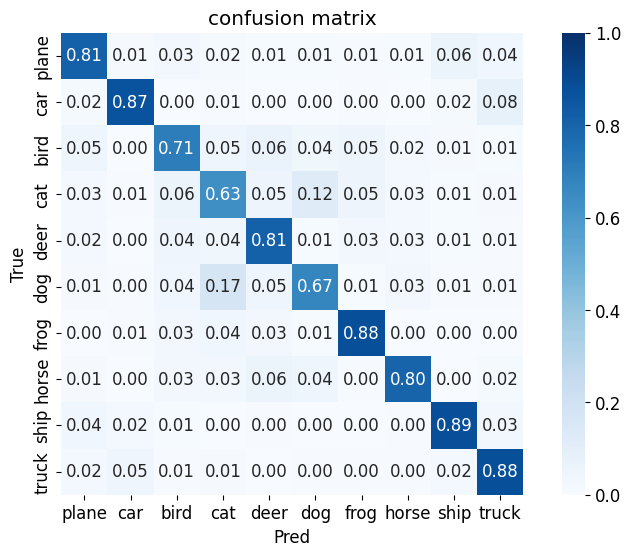

In [ ]:
from sklearn.metrics import confusion_matrix

cmx = confusion_matrix(y_test_all, p_label_all)

cmx_pct = np.zeros(cmx.shape)

for i in range(cmx.shape[0]):
    for j in range(cmx.shape[1]):
        cmx_pct[i, j] = cmx[i, j]/cmx[i, :].sum()

plt.figure(figsize=(10,6))
labels = classnames.values()

sns.heatmap(cmx_pct, annot=True, fmt=".2f", cmap="Blues", vmin=0, vmax=1,
            xticklabels=classnames.values(), yticklabels=classnames.values(), square=True)

plt.ylabel("True")
plt.xlabel("Pred")
plt.title("confusion matrix")

### Predictions for Test Data

Let's see predictions for some test data.

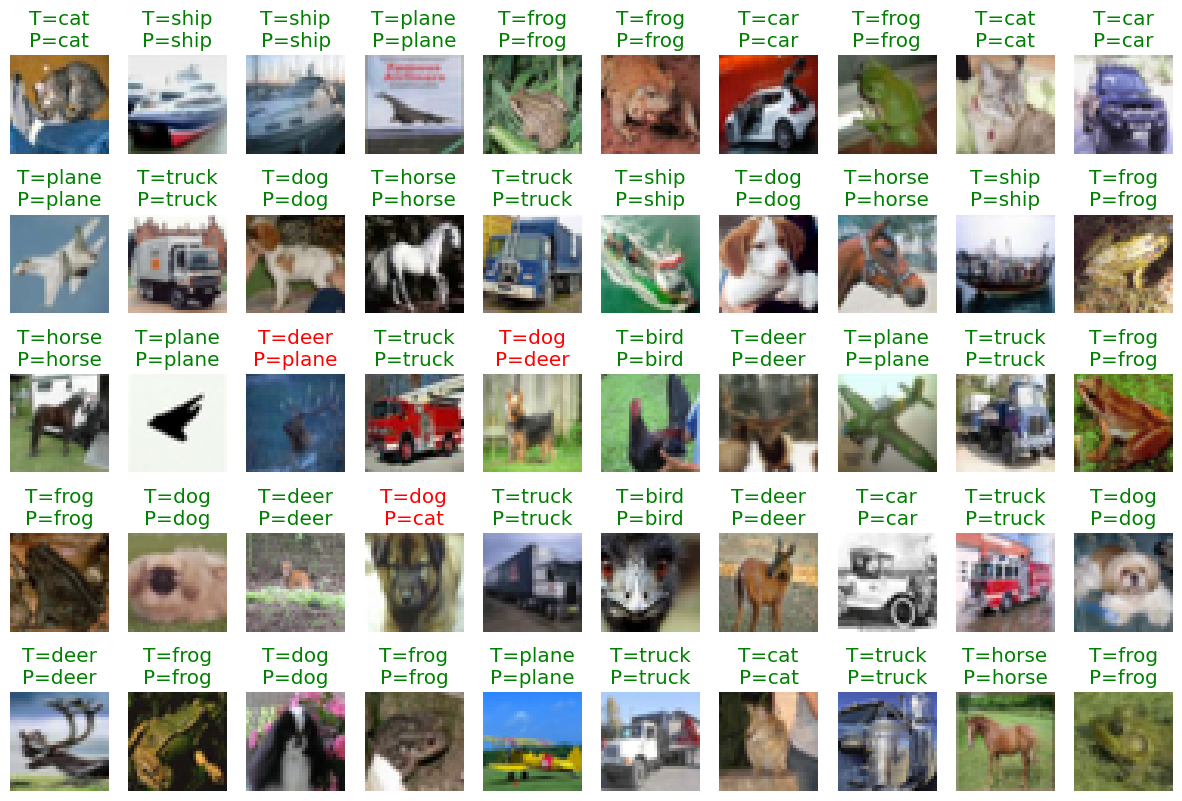

In [ ]:
plt.figure(figsize=(15, 10))

for i in range(50):
    image, _ = test_dataset[i]
    image = np.transpose(image, (1,2,0))

    # if data standardization was applied, uncomment following three lines
    image[:, :, 0] = image[:, :, 0]*stds[0]+means[0]
    image[:, :, 1] = image[:, :, 1]*stds[1]+means[1]
    image[:, :, 2] = image[:, :, 2]*stds[2]+means[2]

    plt.subplot(5, 10, i+1)
    plt.imshow(image)

    true_class = classnames[y_test_all[i]]
    pred_class = classnames[p_label_all[i]]
    if true_class == pred_class:
        color = "green"
    else:
        color = "red"
    plt.title(f"T={true_class}\nP={pred_class}", color=color)
    plt.axis("off")

## Conclusion
That's it for this week. Now you can try to improve the test accuracy by changing data augmentation methods, model architecture, training epochs and so on...